# RCT DoWhy audit code

In [1]:
import numpy as np
import pandas as pd
import dowhy
from dowhy import CausalModel
import dowhy.datasets

from IPython.display import Image, display

import dowhy.datasets, dowhy.plotter

## Step 1: Data import and pre-processing

Load dataset as a Pandas dataframe and use KNN (n=5) to impute missing data. Note that RCT datasets have empty cells, as well as values that represent missing and unknown data, which we will consider to be equal here.

When you proceed to build the model, note that the `CausalModel` function requires a Pandas dataframe for `data=`, list of string of column names for `treatment=`, string for `outcome=`, and the string directory to a `.gml` graph file for `graph=`

In [3]:
EFFICACY = pd.read_csv('/home/alex/Documents/lab/ctci/dat/PDS/Multiple_Allianc_2002_213_NCT00052910_esophageal/NCT00052910_D1_(EFFICACY).csv')

# check for missing values
# EFFICACY.isna().sum()
ef_impute = EFFICACY.drop(columns=['MASK_ID'])  # drop variables that will not help us impute values

# replace missing encoding with NaNs
ef_impute = ef_impute.replace(to_replace=['.',-2], value=np.NaN) # check data dictionary for missing and unknown codes
print(ef_impute.isna().sum())

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ef_impute = pd.DataFrame(scaler.fit_transform(ef_impute), columns = ef_impute.columns)


PERFORMANCE_ID                      0
Hx_oth_cancer                       8
stable_weigh                       16
examed_by_radiation_oncologist      8
bilateral_renal_function           10
No_cardiact_condition               8
prior_chemo                        89
prior_radiation                    89
Gastro_esophageal_junction         62
cardia                             87
fundus                             85
body_corpus                        83
antrum                             82
pylorus_pyloric_channel            90
greater_curvature                  88
lesser_curvature                   80
stomach_NOS                        78
Histologic_grade                   15
num_lymph_node_examined            11
num_pos_lymph_node                 15
T_stage                            12
N_stage                            16
M_stage                            85
T2N0M0_spec                       452
PD_location                       433
ETHNIC_ID                           0
SEX_ID      

In [4]:
# Impute with KNN
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
ef_impute = pd.DataFrame(imputer.fit_transform(ef_impute), columns = ef_impute.columns)
ef_impute = pd.DataFrame(scaler.inverse_transform(ef_impute), columns=ef_impute.columns)

print('Before imputation:')
print(EFFICACY.describe())

print('After imputation:')
print(ef_impute.describe())

ef_impute.isin([-2,'.',np.NaN]).sum() # there shouldn't be missing values anymore

ef_impute = ef_impute.drop(columns=['death_final', 'DFS_status', 'DFS_year'])

Before imputation:
          MASK_ID  PERFORMANCE_ID  Hx_oth_cancer  stable_weigh  \
count  546.000000      546.000000     538.000000    538.000000   
mean   273.500000        0.518315       1.040892      1.927509   
std    157.760895        0.545737       0.198225      0.496117   
min      1.000000        0.000000       1.000000     -2.000000   
25%    137.250000        0.000000       1.000000      2.000000   
50%    273.500000        0.000000       1.000000      2.000000   
75%    409.750000        1.000000       1.000000      2.000000   
max    546.000000        2.000000       2.000000      2.000000   

       examed_by_radiation_oncologist  bilateral_renal_function  \
count                      538.000000                538.000000   
mean                         0.985130                  0.925651   
std                          0.121145                  0.302152   
min                          0.000000                 -2.000000   
25%                          1.000000              

In [5]:
print(ef_impute['TREAT_ASSIGNED'].value_counts())

# If you want to use propensity score matching/stratification/weighting, you need to convert treatment assignment into boolean values
ef_impute['TREAT_ASSIGNED'] = ef_impute['TREAT_ASSIGNED'].transform(func = lambda x: bool(x - 1))

print('After transformation:')

print(ef_impute['TREAT_ASSIGNED'].value_counts())

ef_impute.to_csv('imputed_covar.csv', index = False)

1.0    280
2.0    266
Name: TREAT_ASSIGNED, dtype: int64
After transformation:
False    280
True     266
Name: TREAT_ASSIGNED, dtype: int64


In [212]:
# model with GLM graph
import networkx as nx
import graphviz
graph_path = '/home/alex/Documents/lab/ctci/dat/PDS/Multiple_Allianc_2002_213_NCT00052910_esophageal/prior_knowledge.gml'
knowledge = nx.read_gml(graph_path)


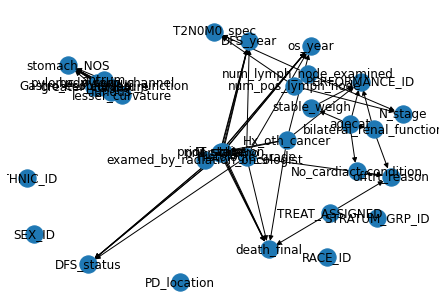

In [213]:
import matplotlib.pyplot as plt
nx.draw(knowledge, with_labels = True)
plt.show()

In [214]:
# put everything into a dictionary
data_dic = {'treatment_name': ['TREAT_ASSIGNED'], 'outcome_name': 'os_year', 'gml_graph': knowledge}
data_dic.keys()

nx.to_dict_of_lists(knowledge)
print(knowledge)
data_dic['treatment_name']


DiGraph with 36 nodes and 79 edges


['TREAT_ASSIGNED']

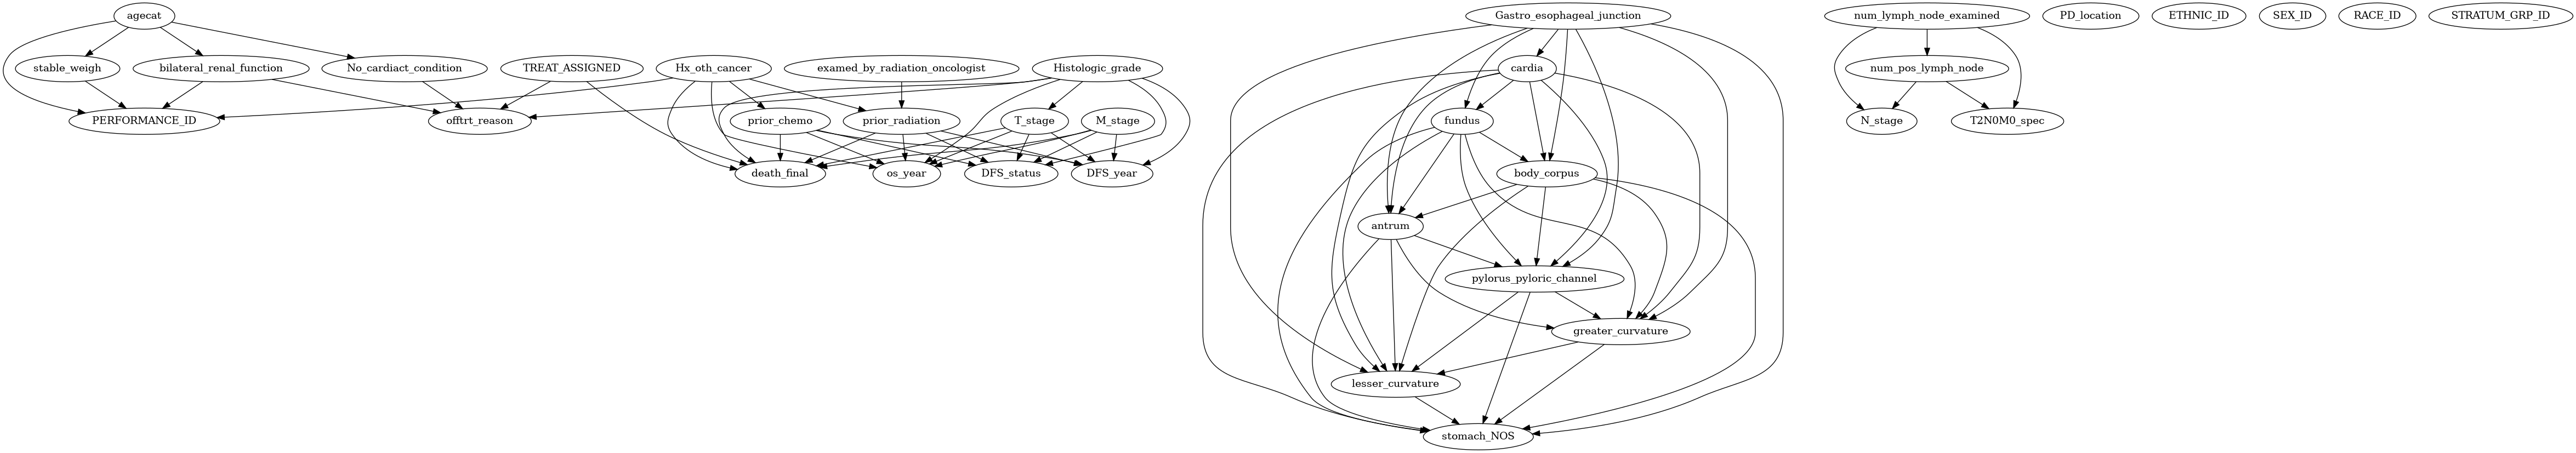

In [215]:
# Build causal model
model = CausalModel(data=ef_impute,
                treatment=data_dic['treatment_name'],
                outcome=data_dic['outcome_name'],
                graph=graph_path
                )

model.view_model()
display(Image(filename="causal_model.png"))

## Step 2: Identify causal effects

In [216]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(Expectation(os_year|num_pos_lymph_node,antrum,Gastro_esophag
d[TREAT_ASSIGNED]                                                             

                                                                              
eal_junction,PERFORMANCE_ID,agecat,N_stage,T2N0M0_spec,No_cardiact_condition,l
                                                                              

                                                                              
esser_curvature,ETHNIC_ID,num_lymph_node_examined,Hx_oth_cancer,greater_curvat
                                                                              

                                                                              
ure,stomach_NOS,stable_weigh,pylorus_pyloric_channel,bilateral_renal_function,
                                

## Step 3: Estimate causal effects

In [217]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print("Causal Estimate is " + str(estimate.value))


/home/alex/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/alex/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Causal Estimate is -0.27551002499505484


## Step 4: Refutation
We will check the validity of causal effect estimation by doing 4 simple test.
1. Adding a random variable (either in form of common cause or latent variable) to the graph and see if it changes the original estimation
2. Replacing treatment with a placebo (randomized treatment)
3. Cross validation by randomly sub-setting the whole dataset

In [173]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:-0.216378082764892
New effect:-0.22256852647820846



In [174]:
res_unobserved=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:-0.216378082764892
New effect:-0.2635643134377017



In [175]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.216378082764892
New effect:-0.02764199978571666
p value:0.48



In [176]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.216378082764892
New effect:-0.2240443412463271
p value:0.45999999999999996



In [177]:
# Doing this again with a random seed
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9, random_seed = 1)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.216378082764892
New effect:-0.21564085005964015
p value:0.5

